In [1]:
import numpy as np
import matplotlib.pyplot as plt
import halotools.mock_observables

%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) 

In [45]:
def compute_correlation_func(log10_stellar_mass, formation_times, positions, min_mass=10.0, max_mass=10.5):
    ii = (log10_stellar_mass>min_mass) & (log10_stellar_mass < max_mass)
    all_pos = positions[ii,:]
    all_formation_z = formation_times[ii]
    percentiles = np.percentile(all_formation_z, [25,75])
    ii_early = all_formation_z > percentiles[1]
    ii_late  = all_formation_z < percentiles[0]
    early_pos = all_pos[ii_early,:]
    late_pos = all_pos[ii_late, :]
    all_corr = {}
    r = np.linspace(5000.0, 10000.0,10)
    all_corr['early'] = halotools.mock_observables.tpcf(early_pos, r, period=205000.0, estimator='Landy-Szalay')
    all_corr['late'] = halotools.mock_observables.tpcf(late_pos, r, period=205000.0, estimator='Landy-Szalay')
    all_corr['all'] = halotools.mock_observables.tpcf(all_pos, r, period=205000.0, estimator='Landy-Szalay')
    all_corr['r'] = 0.5*(r[1:]+r[:-1])
    return all_corr

def compute_ratio(log10_stellar_mass, formation_times, positions):
    log_mass_bins = np.arange(9.0, 11.5, 0.25)
    ratio_late_mean = np.ones(len(log_mass_bins))
    ratio_late_std = ratio_late_mean.copy()
    ratio_early_mean = ratio_late_mean.copy()
    ratio_early_std = ratio_late_mean.copy()

    for i, min_mass_bin in enumerate(log_mass_bins):
        corr = compute_correlation_func(log10_stellar_mass, formation_times, positions, min_mass=min_mass_bin, max_mass=min_mass_bin+0.5)
        ratio_late_mean[i] = np.mean(corr['late']/corr['all'])
        ratio_late_std[i] = np.std(corr['late']/corr['all'])
        ratio_early_mean[i] = np.mean(corr['early']/corr['all'])
        ratio_early_std[i] = np.std(corr['early']/corr['all'])
    return {'log_mass_bins':log_mass_bins, 
            'ratio_late_mean':ratio_late_mean, 'ratio_late_std':ratio_late_std,
            'ratio_early_mean':ratio_early_mean, 'ratio_early_std':ratio_early_std}

def compute_median_assembly(log10_stellar_mass, formation_times):
    log_mass_bins = np.arange(9.0, 11.5, 0.25)
    median_assembly = np.ones(len(log_mass_bins))

    for i, min_mass_bin in enumerate(log_mass_bins):
        ii = (log10_stellar_mass>min_mass_bin) & (log10_stellar_mass < (min_mass_bin+0.5))
        median_assembly[i] = np.median(formation_times[ii])

    return {'log_mass_bins':log_mass_bins, 'median_assembly': median_assembly}

In [46]:
formation_data = np.loadtxt("/Users/forero/Illustris_data/formation_times_TNG300/301/Galaxies/Central_Galaxies/Central_Galaxies.dat")
log10_stellar_mass  = np.log10(formation_data[:,4]) + 10
positions = formation_data[:, 5:]
formation_times = formation_data[:, 3]
ratio_central = compute_ratio(log10_stellar_mass, formation_times, positions)
median_central = compute_median_assembly(log10_stellar_mass, formation_times)

In [47]:
formation_data = np.loadtxt("/Users/forero/Illustris_data/formation_times_TNG300/301/Galaxies/All_Galaxies/ZM_Galaxies3001.dat")
log10_stellar_mass  = np.log10(formation_data[:,4]) + 10
positions = formation_data[:, 5:]
formation_times = formation_data[:, 3]
ratio_all = compute_ratio(log10_stellar_mass, formation_times, positions)
median_all = compute_median_assembly(log10_stellar_mass, formation_times)

In [48]:
formation_data = np.loadtxt("/Users/forero/Illustris_data/formation_times_TNG300/301/Galaxies/Satellite_Galaxies/SatZ_Galaxies.dat")
log10_stellar_mass  = np.log10(formation_data[:,4]) + 10
positions = formation_data[:, 5:]
formation_times = formation_data[:, 3]
ratio_sat = compute_ratio(log10_stellar_mass, formation_times, positions)
median_sat = compute_median_assembly(log10_stellar_mass, formation_times)

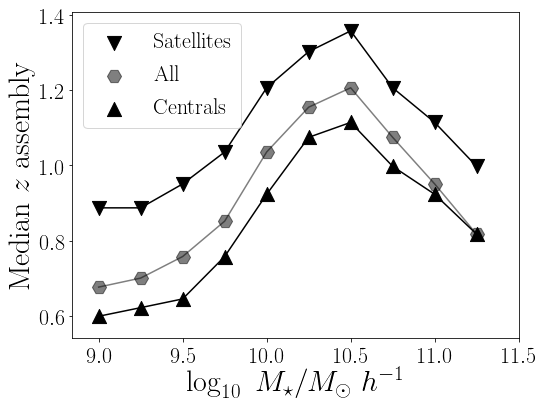

In [60]:
plt.figure(figsize=(8,6))

plt.plot(median_sat['log_mass_bins'], median_sat['median_assembly'], color='black')
plt.scatter(median_sat['log_mass_bins'], median_sat['median_assembly'], marker='v', s=200, label='Satellites', color='black')

plt.plot(median_all['log_mass_bins'], median_all['median_assembly'], color='black', alpha=0.5)
plt.scatter(median_all['log_mass_bins'], median_all['median_assembly'], marker='H', s=200, label='All', color='black', alpha=0.5)

plt.plot(median_central['log_mass_bins'], median_central['median_assembly'], color='black')
plt.scatter(median_central['log_mass_bins'], median_central['median_assembly'], marker='^', s=200, label='Centrals', color='black')

plt.xlabel("$\log_{10}\ M_{\mathrm{\star}} / M_{\odot}\ h^{-1}$")
plt.ylabel("Median $z$ assembly")
plt.legend(fontsize=SMALL_SIZE)
plt.xticks(np.arange(9.0, 12.0, 0.5))

plt.savefig("median_assembly.pdf", bbox_inches='tight')

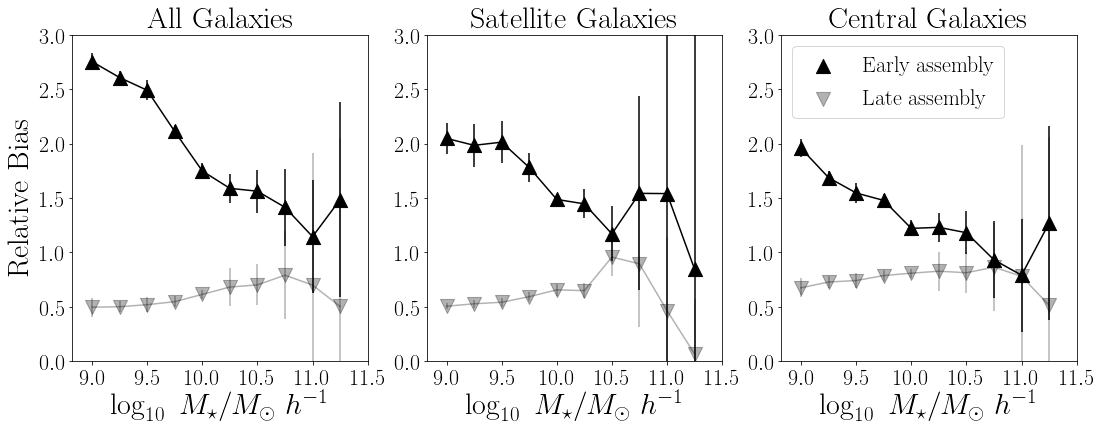

In [61]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.scatter(ratio_all['log_mass_bins'], ratio_all['ratio_early_mean'], marker='^', s=200, color='black', label='Early assembly')
plt.errorbar(ratio_all['log_mass_bins'], ratio_all['ratio_early_mean'], ratio_central['ratio_early_std'], color='black')
plt.scatter(ratio_all['log_mass_bins'], ratio_all['ratio_late_mean'], marker='v', s=200, color='black', alpha=0.3, label='Late assembly')
plt.errorbar(ratio_all['log_mass_bins'], ratio_all['ratio_late_mean'], ratio_central['ratio_late_std'], color='black', alpha=0.3)

plt.title('All Galaxies')
plt.ylim([0.0, 3.0])
plt.xlabel("$\log_{10}\ M_{\mathrm{\star}} / M_{\odot}\ h^{-1}$")
plt.ylabel("Relative Bias")
plt.xticks(np.arange(9.0, 12.0, 0.5))


plt.subplot(1,3,2)
plt.scatter(ratio_sat['log_mass_bins'], ratio_sat['ratio_early_mean'], marker='^', s=200, color='black')
plt.errorbar(ratio_sat['log_mass_bins'], ratio_sat['ratio_early_mean'], ratio_sat['ratio_early_std'], color='black')
plt.scatter(ratio_sat['log_mass_bins'], ratio_sat['ratio_late_mean'], marker='v', s=200, color='black', alpha=0.3)
plt.errorbar(ratio_sat['log_mass_bins'], ratio_sat['ratio_late_mean'], ratio_sat['ratio_late_std'], color='black', alpha=0.3)

plt.title('Satellite Galaxies')
plt.ylim([0.0, 3.0])
plt.xlabel("$\log_{10}\ M_{\mathrm{\star}} / M_{\odot}\ h^{-1}$")
plt.xticks(np.arange(9.0, 12.0, 0.5))


plt.subplot(1,3,3)
plt.scatter(ratio_central['log_mass_bins'], ratio_central['ratio_early_mean'], marker='^', s=200, color='black', label='Early assembly')
plt.errorbar(ratio_central['log_mass_bins'], ratio_central['ratio_early_mean'], ratio_central['ratio_early_std'], color='black')
plt.scatter(ratio_central['log_mass_bins'], ratio_central['ratio_late_mean'], marker='v', s=200, color='black', alpha=0.3, label='Late assembly')
plt.errorbar(ratio_central['log_mass_bins'], ratio_central['ratio_late_mean'], ratio_central['ratio_late_std'], color='black', alpha=0.3)

plt.title('Central Galaxies')
plt.ylim([0.0, 3.0])
plt.legend(fontsize=SMALL_SIZE, loc=2)
plt.xlabel("$\log_{10}\ M_{\mathrm{\star}} / M_{\odot}\ h^{-1}$")
plt.xticks(np.arange(9.0, 12.0, 0.5))

plt.savefig("bias_galaxies.pdf", bbox_inches='tight')

In [51]:
formation_data = np.loadtxt("/Users/forero/Illustris_data/formation_times_TNG300/301/Galaxies/All_Galaxies/ZM_Galaxies3001.dat")
log10_stellar_mass  = np.log10(formation_data[:,4]) + 10
positions = formation_data[:, 5:]
formation_times = formation_data[:, 3]
ratio_all = compute_ratio(log10_stellar_mass, formation_times, positions)

In [68]:
min_mass = 10.0
max_mass = 10.25

ii = (log10_stellar_mass>min_mass) & (log10_stellar_mass < max_mass)
all_pos = positions[ii,:]
all_formation_z = formation_times[ii]
percentiles = np.percentile(all_formation_z, [25,75])
ii_early = all_formation_z >= percentiles[1]
ii_late  = all_formation_z <= percentiles[0]
early_pos = all_pos[ii_early,:]
late_pos = all_pos[ii_late, :]

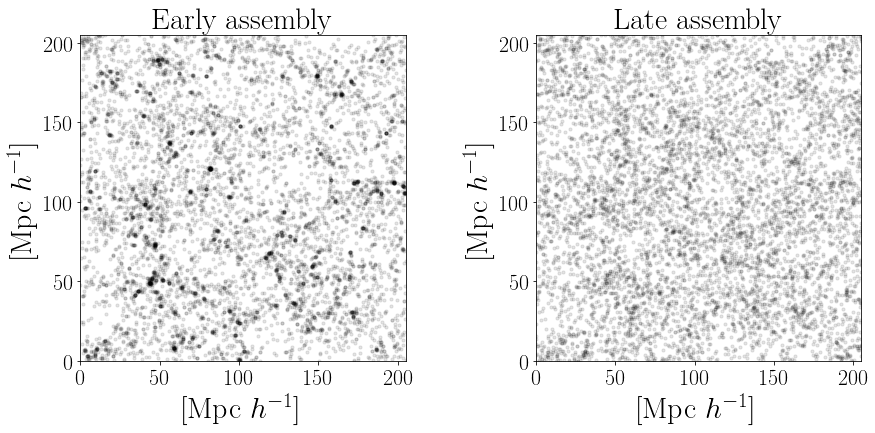

In [69]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ii_z = early_pos[:,2]<210000
plt.scatter(early_pos[ii_z,0]/1000, early_pos[ii_z,1]/1000, s=10.0, alpha=0.1, color='black')
plt.title('Early assembly'.format(int(np.count_nonzero(ii_z)/1000)))
plt.axis('equal')
plt.xlim([0,205])
plt.ylim([0,205])
plt.xlabel("[Mpc $h^{-1}]$")
plt.ylabel("[Mpc $h^{-1}]$")
_ = plt.xticks(np.arange(0,250,50))


plt.subplot(1,2,2)
ii_z = late_pos[:,2]<210000
plt.scatter(late_pos[ii_z,0]/1000, late_pos[ii_z,1]/1000, s=10.0, alpha=0.1, color='black')
plt.title('Late assembly'.format(int(np.count_nonzero(ii_z)/1000)))
plt.axis('equal')
plt.xlim([0,205])
plt.ylim([0,205])
plt.xlabel("[Mpc $h^{-1}]$")
plt.ylabel("[Mpc $h^{-1}]$")
_ = plt.xticks(np.arange(0,250,50))

plt.subplots_adjust(wspace=0.4)
plt.savefig("scatter_assembly.pdf", bbox_inches='tight')

In [63]:
print(len(late_pos[ii_z,1]))

7348
